In [1]:
import pandas as pd
from datetime import timedelta, datetime, time
import random
import numpy as np

In [2]:
full_df = pd.read_csv('full_df')
full_df.drop(columns='Unnamed: 0', inplace=True)
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])

In [3]:
full_df.head()

,timestamp,customer_no,location,day
0,2019-09-02 07:03:00,1,dairy,Monday
1,2019-09-02 07:04:00,1,dairy,Monday
2,2019-09-02 07:05:00,1,checkout,Monday
3,2019-09-02 07:03:00,2,dairy,Monday
4,2019-09-02 07:04:00,2,dairy,Monday


## Customer Class

In [4]:
class Customer:
    "The  class Customer is a blueprint for customers"
    
    def __init__(self, name, state='entrance', budget=100): #initialisation
        self.name = name
        self.state = state
        self.budget = budget
        
    def get_customer_df(self, dataframe):
        customer_df = dataframe[dataframe['customer_no'] == self.name].reset_index()
        #print(customer_df)
    # we add the entrance row
        entry_row = []
        entry_row.append({'timestamp': customer_df['timestamp'][0] - timedelta(minutes=1), 'customer_no':customer_df['customer_no'][0], 'location': 'entrance', 'day': customer_df['day'][0]})
        customer_df = pd.concat([pd.DataFrame(entry_row), customer_df]).reset_index()
        customer_df.drop(columns=['index'],inplace=True)

        # we add the checkout row
        checkout_row = []
        checkout_row.append({'timestamp': customer_df['timestamp'].iloc[-1] + timedelta(minutes=1), 'customer_no':customer_df['customer_no'].loc[0], 'location': 'checkout', 'day': customer_df['day'].loc[0]})
        customer_df = pd.concat([customer_df,pd.DataFrame(checkout_row)]).reset_index()
        customer_df.drop(columns=['index'],inplace=True)

        # we append the latest customer_df to the new_full_df dataframe
        #new_full_df = pd.concat([new_full_df, customer_df])
        
        return customer_df
    
    #def next_state(self):
        """Propagates the customer to the next state.
        Returns nothing."""
        #self.state = random.choice(['spices', 'drinks', 'fruit'])
        #return self.state
        
    @property
    def is_active(self):
        if self.state != 'checkout':
            return True
        else:
            return False
            

    def create_matrix(self, dataframe):
        
        # the .copy() allows to get rid of the SettingCopyWithWarning message!
        customer_df = dataframe.loc[dataframe['customer_no'] == self.name].copy()
        customer_df['next_location'] = customer_df['location'].shift(-1)
        customer_df = customer_df.groupby('location')['next_location'].value_counts(normalize=True).unstack()
        return customer_df
    
    def next_state(self):
        location = np.array([])
        if self.state == 'entrance':
            location = np.array([1,0,0,0,0,0])
        if self.state == 'dairy':
            location = np.array([0,1,0,0,0,0])
        if self.state == 'drinks':
            location = np.array([0,0,1,0,0,0])
        if self.state == 'fruit':
            location = np.array([0,0,0,1,0,0])
        if self.state == 'spices':
            location = np.array([0,0,0,0,1,0])
        if self.state == 'checkout':
            location = np.array([0,0,0,0,0,1])
            
        #next_location_proba = location.dot(transition_matrix_2)
        next_location = np.random.choice(['dairy', 'drinks','fruit','spices','checkout'], p=transition_matrix_2.loc[self.state])
        self.state = next_location
        return next_location
    
    def __repr__(self): 
        return f'This is a customer with the customer number {self.name}'
    
    """    # Instead of calling the attribute directly, it is good to have a "getter" function to return its current value
    def get_health(self):
        return self.health
    
    # Same for setting values:
    def set_health(self, value):
        self.health = value
    
    # Can also do operations on attributes to change them
    def add_health(self, value):
        self.health += value""";

## Transition Matrix

In [5]:
# we want to create a dataframe containing all the new entry rows and checkout rows 
# generated by Customer.get_customer_df()

test_full_df = pd.DataFrame()

for customer_no in full_df['customer_no'].unique():
    customer_df = Customer(customer_no).get_customer_df(full_df)
    test_full_df = pd.concat([test_full_df, customer_df])
test_full_df.drop(columns=['level_0'], inplace=True)

In [6]:
# we now create a next location column to allow for the creation of our transition matrix

test_full_df['next_location'] = test_full_df['location'].shift(-1)
test_full_df.reset_index(drop=True, inplace=True)

# we want checkout to be the final state so we delete any row where customers go from checkout to entrance

test_full_df.drop(test_full_df[test_full_df['next_location'] == 'entrance'].index, inplace=True)
test_full_df.reset_index(drop=True)

# the last value of location is empty, we'll fill it

test_full_df.fillna(method='ffill', inplace=True)

In [7]:
# now we can create our transition matrix

transition_matrix_2 = pd.crosstab(test_full_df['location'], test_full_df['next_location'], normalize='index')

In [8]:
# we'll make sure entrance is the first row and checkout the last row
transition_matrix_2 = transition_matrix_2.reindex(["entrance","dairy", "drinks", "fruit","spices","checkout"])[["dairy", "drinks", "fruit","spices","checkout"]]
transition_matrix_2

next_location,dairy,drinks,fruit,spices,checkout
location,,,,,
entrance,0.287576,0.153526,0.377435,0.181464,0.000000
dairy,0.737886,0.058316,0.049633,0.051146,0.103019
drinks,0.010889,0.598870,0.087827,0.086903,0.215511
fruit,0.095638,0.054684,0.598148,0.050526,0.201004
spices,0.192448,0.162462,0.090592,0.404411,0.150087
checkout,0.000000,0.000000,0.000000,0.000000,1.000000


## Customer Class and matrix QA

In [9]:
# tests of the customer class
Customer1 = Customer(1)

In [10]:
print('Current state: ' +Customer1.state)
print('Next state: ' + Customer1.next_state())
print('Updated current state: ' +Customer1.state)

Current state: entrance
Next state: fruit
Updated current state: fruit


In [11]:
customer_df = Customer(7).create_matrix(full_df)
customer_df

next_location,checkout,drinks,fruit,spices
location,,,,
drinks,NaN,0.750000,NaN,0.250000
fruit,0.5,NaN,0.500000,NaN
spices,NaN,0.333333,0.333333,0.333333


## Supermarket Class

Example Pseudocode:

- increase the time of the supermarket by one minute

- for every customer determine their next state

- remove churned customers from the supermarket

- generate new customers at their initial location

- repeat from step 1

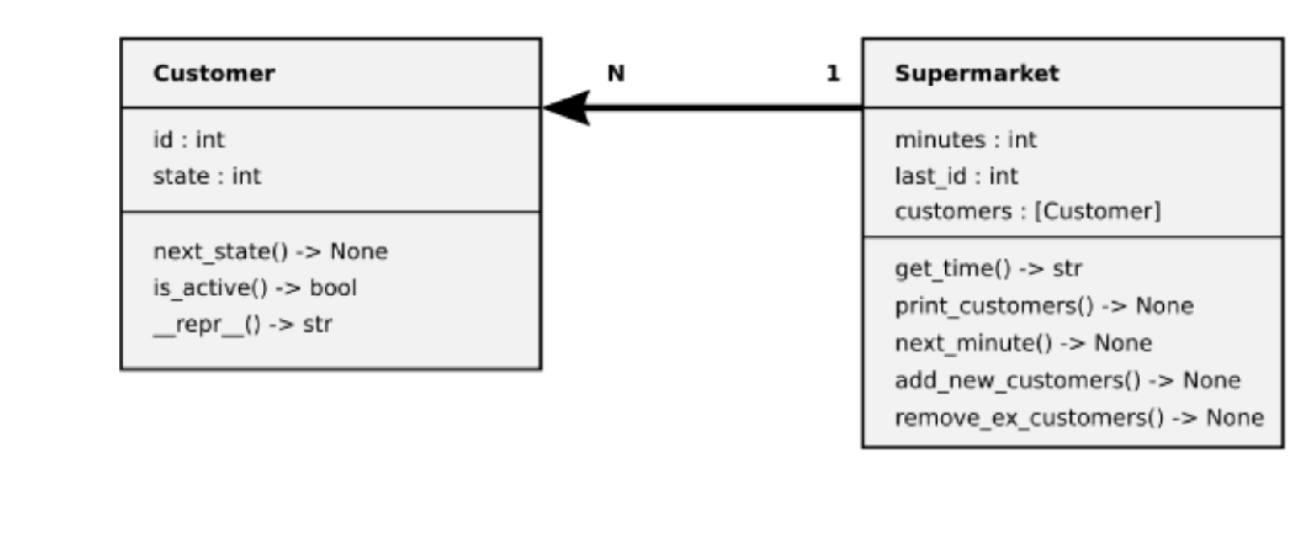

In [12]:
column_names = ["timestamp", "customer_no", "location"]
sim_df = pd.DataFrame(columns = column_names)
sim_df

,timestamp,customer_no,location


In [13]:
class Supermarket:
    """this represents an instance of supermarket"""

    def __init__(self):

        self.minute = datetime.strptime('07:00', "%H:%M")
        self.last_name = 1
        self.customers= []

    def get_time(self):
        return self.minute
        
    def print_customers():
        print()

    def next_minute(self):
        """propagates all customers to the next state."""
        """current time in HH:MM format,"""
        current_time = (self.minute + timedelta(minutes=1))
        self.minute = current_time
        return current_time
        
    def change_state(self):
        for customer in self.customers:
            customer.next_state()
        
    
    def add_new_customers(self, number):
        
        max_id = 0
        new_customers = range(number)
        for customer in new_customers:
            self.customers.append(Customer(self.last_name))
            self.last_name += 1
        return self.customers
        
    def remove_ex_customers(self):
        self.customers = [customer for customer in self.customers if customer.is_active]
        
        
    def execute_all(self):
        
        global sim_df
        self.next_minute()
        self.change_state()
        self.add_new_customers(2)
        for customer in self.customers:
            
            to_append2 = [{'timestamp': self.minute.time(), 'customer_no': customer.name, 'location': customer.state}]
            #to_append1 = pd.Series([self.minute, customer.name, customer.state])
            sim_df = sim_df.append(to_append2)
            sim_df = sim_df.sort_values(['customer_no', 'timestamp'])
            sim_df.reset_index(inplace=True, drop=True)
            #print(customer)
            #print(customer.state)
        self.remove_ex_customers()

In [14]:
supermarket1 = Supermarket()

In [15]:
for i in range(120):
    supermarket1.execute_all()

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(to_append2)
/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_42514/3969208963.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_df = sim_df.append(

In [16]:
sim_df.to_csv('simulation_df.csv')

In [17]:
sim_df.head(25)

,timestamp,customer_no,location
0,07:01:00,1,entrance
1,07:02:00,1,fruit
2,07:03:00,1,fruit
3,07:04:00,1,drinks
4,07:05:00,1,spices
5,07:06:00,1,fruit
6,07:07:00,1,checkout
7,07:01:00,2,entrance
8,07:02:00,2,fruit
9,07:03:00,2,fruit


In [18]:
for i in range(10):
    print(sim_df[sim_df['customer_no'] == i])


Empty DataFrame
Columns: [timestamp, customer_no, location]
Index: []
  timestamp customer_no  location
0  07:01:00           1  entrance
1  07:02:00           1     fruit
2  07:03:00           1     fruit
3  07:04:00           1    drinks
4  07:05:00           1    spices
5  07:06:00           1     fruit
6  07:07:00           1  checkout
   timestamp customer_no  location
7   07:01:00           2  entrance
8   07:02:00           2     fruit
9   07:03:00           2     fruit
10  07:04:00           2     fruit
11  07:05:00           2     fruit
12  07:06:00           2     fruit
13  07:07:00           2  checkout
   timestamp customer_no  location
14  07:02:00           3  entrance
15  07:03:00           3    spices
16  07:04:00           3    spices
17  07:05:00           3    spices
18  07:06:00           3     dairy
19  07:07:00           3     dairy
20  07:08:00           3    drinks
21  07:09:00           3  checkout
   timestamp customer_no  location
22  07:02:00           4  en